# LSTM 

# SINGLE

In [8]:
#V0402

import pandas as pd
import matplotlib.pyplot as plt
# load the data
df = pd.read_csv('single.txt', encoding='ISO-8859-1')
polarity_map = {'positive': 1, 'negative': -1, 'neutral': 0}
df['text_polarity'] = df['text'].map(polarity_map)

In [9]:
df

,Unnamed: 0,ID,text,image,tweet,text_polarity
0,0,1,neutral,positive,How I feel today #legday #jelly #aching #gym \n,0
1,1,2,neutral,positive,grattis min griskulting!!!???? va bara tvungen...,0
2,2,3,neutral,positive,RT @polynminion: The moment I found my favouri...,0
3,3,4,positive,positive,#escort We have a young and energetic team and...,1
4,4,5,positive,positive,"RT @chrisashaffer: Went to SSC today to be a ""...",1
...,...,...,...,...,...,...
4864,4864,5125,neutral,positive,http://t.co/Y4ZrSmq2KB http://t.co/LÂ¡Â­\n,0
4865,4865,5126,positive,neutral,YES! #sinful #food #freefrom #glutenfree #suga...,1
4866,4866,5127,positive,positive,"RT @bookmyshow: #Disney's lies - ""Every day is...",1
4867,4867,5128,neutral,positive,RT @MUBMI: TWO MORE DAYS to submit your apps #...,0


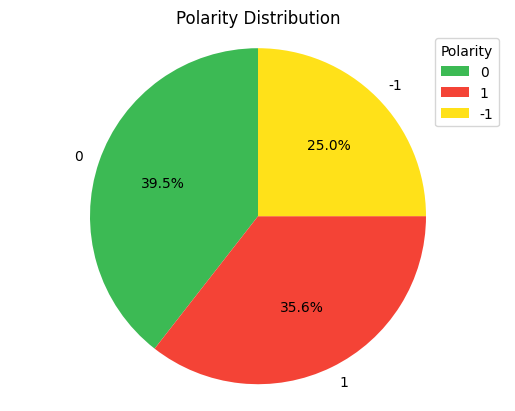

In [10]:
# distribution of polarity
polarity_counts = df['text_polarity'].value_counts(normalize=True)

# assign colors for each category
colors = ['#3cba54', '#f44336', '#ffe119']

# Create a pie chart of the polarity distribution
plt.pie(polarity_counts.values, labels=polarity_counts.index, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Polarity Distribution')
plt.legend(title='Polarity', loc='best')
plt.show()

In [11]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# Download stopwords and punkt tokenizer if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')

# Define a function to preprocess text
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove URLs using regex
    text = re.sub(r'http\S+', '', text)
    
    # Remove punctuation using regex
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize text into individual words
    words = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Stem words using Porter Stemmer
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    
    # Join words back into a single string
    text = ' '.join(words)
    
    return text

# Apply the preprocess_text function to the 'tweet' column of the dataframe
df['tweet'] = df['tweet'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ausco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ausco\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


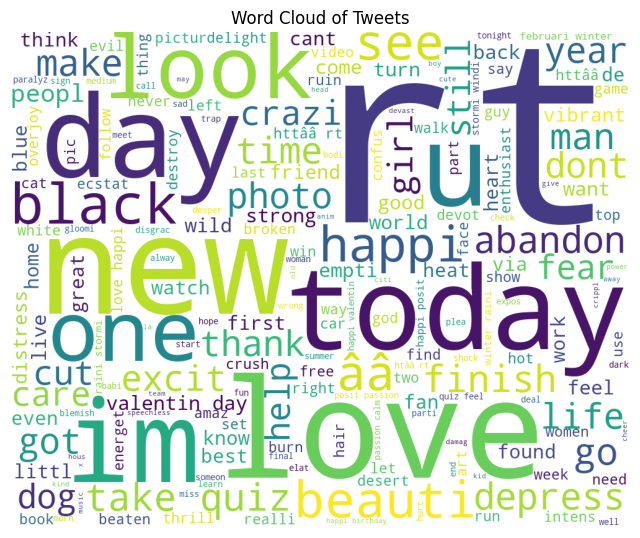

In [14]:
from wordcloud import WordCloud
import pandas as pd

# Join all tweets into a single string
text = ' '.join(df['tweet'])

# Create a word cloud of the tweets
wordcloud = WordCloud(width=1000, height=800, background_color='white').generate(text)
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Word Cloud of Tweets')
plt.show()

In [15]:
import numpy as np
from time import time
import pandas as pd
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, Dropout, Conv1D, MaxPooling1D, Flatten, Dense
from keras.models import Model
from sklearn.model_selection import train_test_split

In [16]:
from keras.layers import LSTM
from keras.layers import Input, Conv1D, MaxPooling1D, Bidirectional, LSTM, concatenate, Dense, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.regularizers import l2
from tensorflow.keras.models import Sequential
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.layers import LSTM, AveragePooling1D
from keras.layers import Input, Dense, LSTM, AveragePooling1D, Reshape
def preprocess_data(df):
    tokenizer = Tokenizer(num_words=5000, split=' ')
    tokenizer.fit_on_texts(df['tweet'].values)
    X = tokenizer.texts_to_sequences(df['tweet'].values)
    X = pad_sequences(X)
    y = pd.get_dummies(df['text_polarity']).values
    return X, y


from keras import regularizers

def build_lstm_model(input_shape):
    af = 'tanh'
    inputs = Input(shape=input_shape)

    x = Embedding(5000, 200, input_length=input_shape[0])(inputs)
    x = Dropout(0.3)(x)
    x = LSTM(128, activation=af, kernel_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.01))(x)
    x = Dense(64, activation=af, kernel_regularizer=regularizers.l2(0.01))(x)
    x = Reshape((-1, 64))(x)
    x = AveragePooling1D(pool_size=1)(x)
    x = Flatten()(x)
    x = Dense(256, activation=af)(x)
    x = Dropout(0.3)(x)
    x = Dense(3, activation=af, kernel_regularizer=regularizers.l2(0.01))(x)

    # Add MDL regularization term
    #mdl_loss = 0.01 * K.sum([K.sum(K.square(w)) for w in model.trainable_weights])
    #model.add_loss(mdl_loss)

    outputs = Dense(3, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(f"Activation Function:{af}")
    return model


def split_data(df):
    X, y = preprocess_data(df)  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # split the remaining data into validation and test sets
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

def train_lstm_model(df):
    X, y = preprocess_data(df)
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(df)
    
    input_shape = X.shape[1:]    
    model = build_lstm_model(input_shape)
     # Train the model on the training set, with validation set for early stopping
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=128)
    
    # Evaluate the model on the test set
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print('Test loss:', loss)
    print('Test accuracy:', accuracy)
    
    return model, history


In [36]:
X, y = preprocess_data(df)
X.shape[1:]

(25,)

In [18]:
lstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 25)]              0         
                                                                 
 embedding (Embedding)       (None, 25, 200)           1000000   
                                                                 
 dropout (Dropout)           (None, 25, 200)           0         
                                                                 
 lstm (LSTM)                 (None, 128)               168448    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 reshape (Reshape)           (None, 1, 64)             0         
                                                                 
 average_pooling1d (AverageP  (None, 1, 64)            0     

In [17]:
# Train
lstm_model,lstm_history = train_lstm_model(df)

Activation Function:tanh
Epoch 1/10
31/31 [==============================] - 9s 135ms/step - loss: 4.3294 - accuracy: 0.4334 - val_loss: 2.8481 - val_accuracy: 0.4784
Epoch 2/10
31/31 [==============================] - 3s 96ms/step - loss: 2.0896 - accuracy: 0.5807 - val_loss: 1.6492 - val_accuracy: 0.5483
Epoch 3/10
31/31 [==============================] - 3s 98ms/step - loss: 1.2014 - accuracy: 0.6750 - val_loss: 1.2576 - val_accuracy: 0.5524
Epoch 4/10
31/31 [==============================] - 3s 101ms/step - loss: 0.8721 - accuracy: 0.7107 - val_loss: 1.1583 - val_accuracy: 0.5380
Epoch 5/10
31/31 [==============================] - 3s 103ms/step - loss: 0.7242 - accuracy: 0.7517 - val_loss: 1.1295 - val_accuracy: 0.5565
Epoch 6/10
31/31 [==============================] - 3s 96ms/step - loss: 0.6399 - accuracy: 0.8056 - val_loss: 1.1202 - val_accuracy: 0.5380
Epoch 7/10
31/31 [==============================] - 3s 110ms/step - loss: 0.5812 - accuracy: 0.8496 - val_loss: 1.1933 - val_a

In [37]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

def print_classification_report(model, X_test, y_test):
    # Generate the predicted labels
    y_pred = model.predict(X_test)

    # Convert the predicted probabilities to class labels
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)
 

    # Generate the classification report
    report = classification_report(y_true_labels, y_pred_labels)
    print(report)
    # Compute the macro-averaged F1 score
    f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')
    print('F1 score:', f1)

In [38]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(df)
print_classification_report(lstm_model, X_test, y_test)

16/16 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

           0       0.32      0.34      0.33       118
           1       0.60      0.64      0.62       187
           2       0.65      0.59      0.62       182

    accuracy                           0.55       487
   macro avg       0.52      0.52      0.52       487
weighted avg       0.55      0.55      0.55       487

F1 score: 0.5482838000286523


In [24]:
from sklearn.metrics import roc_curve, auc

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

def plot_roc_curve(model, X_test, y_test):
    from sklearn.metrics import roc_curve, auc, roc_auc_score
    import matplotlib.pyplot as plt

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    #  each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(y_test.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = roc_auc_score(y_test, y_pred, average="micro")

    # Plot ROC curves
    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (AUC = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             linewidth=2)

    for i in range(y_test.shape[1]):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (AUC = {1:0.2f})'
                                       ''.format(i, roc_auc[i]),
                 linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


In [25]:
import matplotlib.pyplot as plt
def plot_hist(history, title):
    """
    Vars:
    - history: A Keras History object representing the training history of a model.
    """
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))
    
    ax1.plot(history.history['accuracy'], c= 'b')
    ax1.plot(history.history['val_accuracy'], c='r')
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Val'], loc='upper left')

    ax2.plot(history.history['loss'], c='m')
    ax2.plot(history.history['val_loss'], c='c')
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Val'], loc='upper left')
     # Add a title to the entire image
    fig.suptitle(title, fontsize=14)
    plt.show()

In [72]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(df)
y_pred = lstm_model.predict(X_test)
print_classification_report(lstm_model, X_test, y_test)

16/16 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.61      0.48      0.54       118
           1       0.60      0.71      0.65       187
           2       0.68      0.65      0.66       182

    accuracy                           0.63       487
   macro avg       0.63      0.61      0.62       487
weighted avg       0.63      0.63      0.63       487

F1 score: 0.6303901437371663


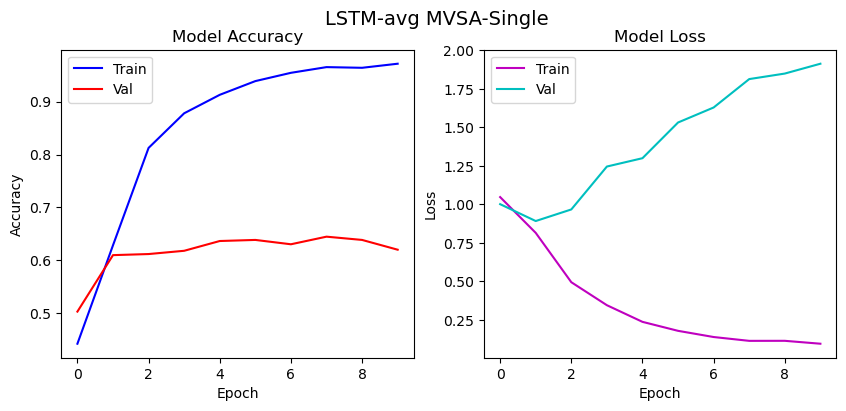

In [73]:
plot_hist(lstm_history,'LSTM-avg MVSA-Single')

16/16 [==============================] - 0s 5ms/step


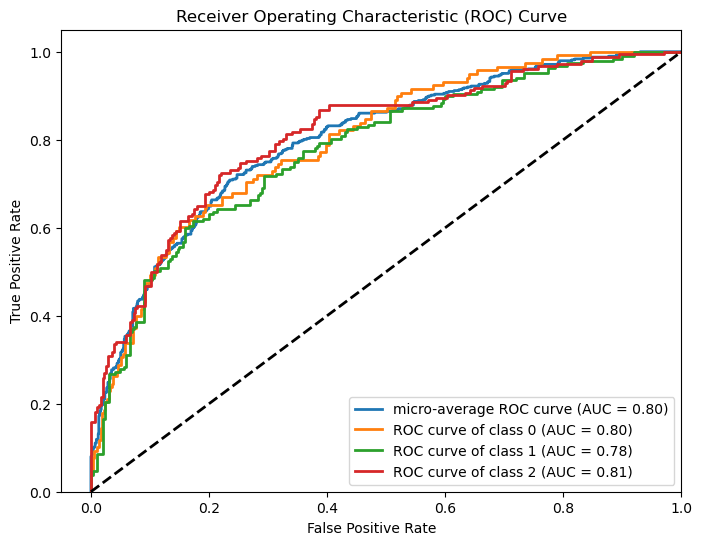

In [74]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(df)
plot_roc_curve(lstm_model, X_test, y_test)

# Multple


In [117]:
import pandas as pd
import matplotlib.pyplot as plt
# load the data
dfm = pd.read_csv('multiple.txt', encoding='ISO-8859-1')


In [118]:
# Define a dictionary to map the labels to their corresponding numerical values
label_map = {'positive': 1, 'neutral': 0, 'negative': -1}

# Replace the labels with their numerical values using the `replace()` method
dfm[['text', 'image', 'text.1', 'image.1', 'text.2', 'image.2']] = \
    dfm[['text', 'image', 'text.1', 'image.1', 'text.2', 'image.2']].replace(label_map)

In [119]:
dfm= dfm[['ID', 'text', 'text.1', 'text.2', 'tweet']]
dfm

,ID,text,text.1,text.2,tweet
0,2499,1,0,1,Knocked doors with the venerable #TeamTrudeau ...
1,2500,0,1,0,Canvassing for @ElectKellyYEG #yegfed #elxn42
2,2501,-1,0,1,An NPD gov't would institutionalize mediocrity...
3,2502,1,1,1,"""""I think it's time for change"""" - Ana Commit ..."
4,2503,1,1,1,The Past and Future of the Refugee Crisis - Th...
...,...,...,...,...,...
19595,22887,1,-1,1,It's texts like these that make my day
19596,22888,1,0,1,@asarimommy_ it was this before
19597,22889,1,1,0,@saddlehillsab deadline extended for County #s...
19598,22890,-1,0,0,im dead


In [120]:
def calculate_polarity(row):
    text_sum = row['text'] + row['text.1'] + row['text.2']
    if text_sum > 0:
        return 1
    elif text_sum < 0:
        return -1
    else:
        return 0

# Apply the function to each row of the DataFrame
dfm['text_polarity'] = dfm.apply(calculate_polarity, axis=1)


In [121]:
dfm

,ID,text,text.1,text.2,tweet,text_polarity
0,2499,1,0,1,Knocked doors with the venerable #TeamTrudeau ...,1
1,2500,0,1,0,Canvassing for @ElectKellyYEG #yegfed #elxn42,1
2,2501,-1,0,1,An NPD gov't would institutionalize mediocrity...,0
3,2502,1,1,1,"""""I think it's time for change"""" - Ana Commit ...",1
4,2503,1,1,1,The Past and Future of the Refugee Crisis - Th...,1
...,...,...,...,...,...,...
19595,22887,1,-1,1,It's texts like these that make my day,1
19596,22888,1,0,1,@asarimommy_ it was this before,1
19597,22889,1,1,0,@saddlehillsab deadline extended for County #s...,1
19598,22890,-1,0,0,im dead,-1


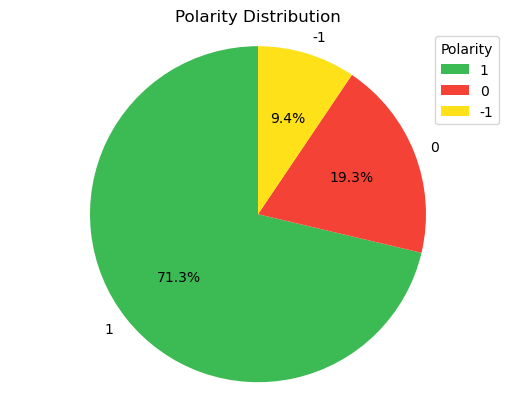

In [122]:
# distribution of polarity
polarity_counts = dfm['text_polarity'].value_counts(normalize=True)

# assign colors for each category
colors = ['#3cba54', '#f44336', '#ffe119']

# Create a pie chart of the polarity distribution
plt.pie(polarity_counts.values, labels=polarity_counts.index, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Polarity Distribution')
plt.legend(title='Polarity', loc='best')
plt.show()

In [123]:
# Apply the preprocess_text function to the 'tweet' column of the dataframe
dfm['tweet'] = dfm['tweet'].apply(preprocess_text)

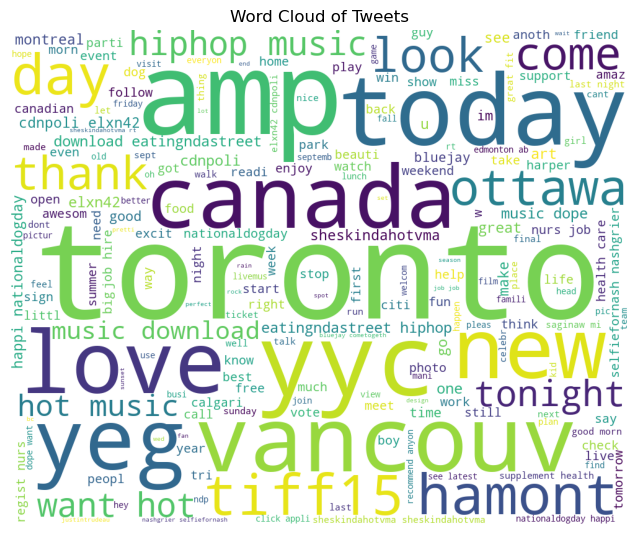

In [124]:
from wordcloud import WordCloud
import pandas as pd

# Join all tweets into a single string
text = ' '.join(dfm['tweet'])

# Create a word cloud of the tweets
wordcloud = WordCloud(width=1000, height=800, background_color='white').generate(text)
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Word Cloud of Tweets')
plt.show()

In [32]:
dfm = pd.read_csv("multi.txt", encoding = "UTF-8")
# Train
lstm_model2,lstm_history2 = train_lstm_model(dfm)

Activation Function:tanh
Epoch 1/10
122/122 [==============================] - 13s 84ms/step - loss: 2.0870 - accuracy: 0.7108 - val_loss: 0.8962 - val_accuracy: 0.7081
Epoch 2/10
122/122 [==============================] - 11s 86ms/step - loss: 0.7751 - accuracy: 0.7179 - val_loss: 0.7530 - val_accuracy: 0.7117
Epoch 3/10
122/122 [==============================] - 11s 93ms/step - loss: 0.6846 - accuracy: 0.7333 - val_loss: 0.7594 - val_accuracy: 0.7112
Epoch 4/10
122/122 [==============================] - 10s 82ms/step - loss: 0.6479 - accuracy: 0.7452 - val_loss: 0.7468 - val_accuracy: 0.7040
Epoch 5/10
122/122 [==============================] - 11s 91ms/step - loss: 0.6229 - accuracy: 0.7558 - val_loss: 0.7658 - val_accuracy: 0.6968
Epoch 6/10
122/122 [==============================] - 10s 83ms/step - loss: 0.6095 - accuracy: 0.7623 - val_loss: 0.7795 - val_accuracy: 0.6891
Epoch 7/10
122/122 [==============================] - 10s 83ms/step - loss: 0.5938 - accuracy: 0.7715 - val_los

In [31]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(dfm)
print_classification_report(lstm_model2, X_test, y_test)

61/61 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       181
           1       0.00      0.00      0.00       333
           2       0.74      1.00      0.85      1433

    accuracy                           0.74      1947
   macro avg       0.25      0.33      0.28      1947
weighted avg       0.54      0.74      0.62      1947

F1 score: 0.7360041088854649


C:\Users\ausco\.conda\envs\new\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ausco\.conda\envs\new\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ausco\.conda\envs\new\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


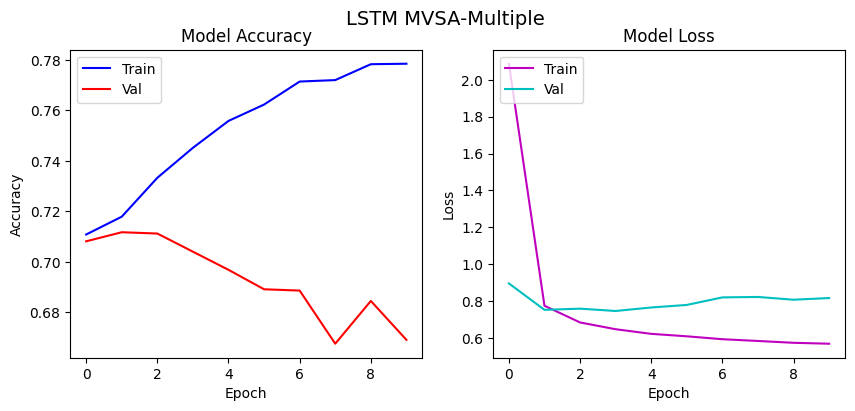

In [33]:
plot_hist(lstm_history2, 'LSTM MVSA-Multiple')

61/61 [==============================] - 1s 8ms/step


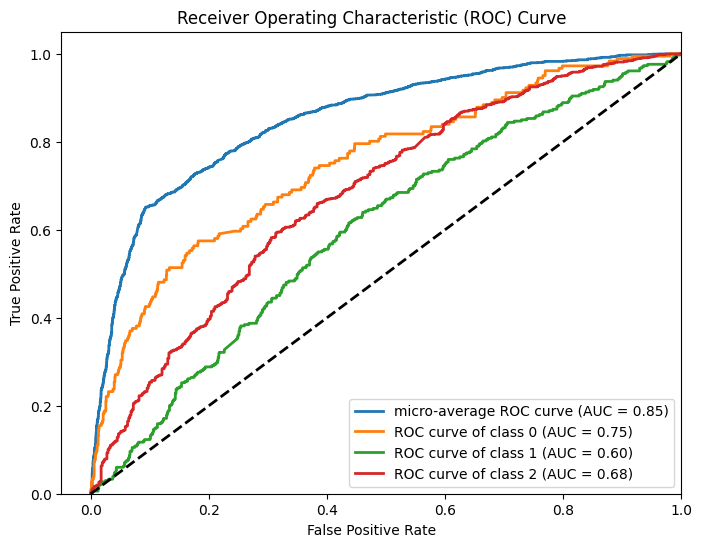

In [34]:
plot_roc_curve(lstm_model2, X_test, y_test)